<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="https://mng.bz/lZ5B">Build a Reasoning Model (From Scratch)</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/reasoning-from-scratch">https://github.com/rasbt/reasoning-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="https://mng.bz/lZ5B"><img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 4: Improving Reasoning with Inference-Time Scaling

Packages that are being used in this notebook:

In [1]:
from importlib.metadata import version

used_libraries = [
    "matplotlib",
    "reasoning_from_scratch",
    "torch",
    "tokenizers"  # Used by reasoning_from_scratch
]

for lib in used_libraries:
    print(f"{lib} version: {version(lib)}")

matplotlib version: 3.10.3
reasoning_from_scratch version: 0.1.9
torch version: 2.9.0
tokenizers version: 0.21.2


<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F01_raschka.webp" width=600>

&nbsp;
## 4.1 Introduction to inference-time scaling

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F02_raschka.webp" width=600>

- Plot above inspired by OpenAI o1 blog post, https://openai.com/index/learning-to-reason-with-llms/

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F03_raschka.webp" width=600>

- All 3 methods more than double the accuracy of the base model on MATH-500 (the benchmark from the prev. chapter)
- Methods 1 and 2 are covered in this chapter; method 3 is covered in the next chapter

&nbsp;
## 4.2 Loading a pre-trained model

- Model loading code similar to chapters 2 and 3

In [2]:
import torch
from reasoning_from_scratch.ch02 import get_device
from reasoning_from_scratch.ch03 import (
     load_model_and_tokenizer
)

device = get_device()

# Use CPU for the first run of this chapter
device = torch.device("cpu")

model, tokenizer = load_model_and_tokenizer(
    which_model="base",
    device=device,
    use_compile=False
)

Using Apple Silicon GPU (MPS)
✓ qwen3/qwen3-0.6B-base.pth already up-to-date


- Let's try the model on a prompt from the MATH-500 dataset, which we worked with in the previous chapter:

In [3]:
from reasoning_from_scratch.ch03 import render_prompt

raw_prompt = (
    "Half the value of $3x-9$ is $x+37$. "
    "What is the value of $x$?"
)
prompt = render_prompt(raw_prompt)

print(prompt)

You are a helpful math assistant.
Answer the question and write the final result on a new line as:
\boxed{ANSWER}

Question:
Half the value of $3x-9$ is $x+37$. What is the value of $x$?

Answer:


- The following function is based on `generate_text_stream_concat` from the previous chapter, but we modify it slightly to be able to pass in other `generate_*` functions later

In [4]:
from reasoning_from_scratch.ch02_ex import generate_text_basic_stream_cache


def generate_text_stream_concat_flex(
    model, tokenizer, prompt, device, max_new_tokens,
    verbose=False, 
    generate_func=None,  # New
    **generate_kwargs  # New
):

    if generate_func is None:  # New
        generate_func = generate_text_basic_stream_cache
        
    input_ids = torch.tensor(
        tokenizer.encode(prompt), device=device
        ).unsqueeze(0)

    generated_ids = []
    for token in generate_func(  # New
        model=model,
        token_ids=input_ids,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id,
        **generate_kwargs,  # New
    ):
        next_token_id = token.squeeze(0)
        generated_ids.append(next_token_id.item())

        if verbose:
            print(
                tokenizer.decode(next_token_id.tolist()),
                end="",
                flush=True
            )
    return tokenizer.decode(generated_ids)

In [5]:
response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_basic_stream_cache  # NEW
)

 \boxed{20}

- By the way, the correct answer is 83

&nbsp;
## 4.3 Generating better responses with chain-of-thought prompting

- A classic way to improve model performance is to modify the prompt to encourage the model to think or explain step by step

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F04_raschka.webp" width=600>

In [6]:
prompt_cot = prompt + " \n\nExplain step by step."

response_cot = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
)

 To solve the problem, we need to find the value of \( x \) such that half the value of \( 3x - 9 \) is equal to \( x + 37 \).

### Step 1: Set up the equation
We are given that half the value of \( 3x - 9 \) is equal to \( x + 37 \). This can be written as:
\[
\frac{1}{2}(3x - 9) = x + 37
\]

### Step 2: Eliminate the fraction
To eliminate the fraction, multiply both sides of the equation by 2:
\[
2 \cdot \frac{1}{2}(3x - 9) = 2(x + 37)
\]
Simplifying both sides:
\[
3x - 9 = 2x + 74
\]

### Step 3: Solve for \( x \)
Subtract \( 2x \) from both sides to isolate \( x \):
\[
3x - 2x - 9 = 74
\]
Simplify:
\[
x - 9 = 74
\]
Add 9 to both sides to solve for \( x \):
\[
x = 74 + 9
\]
\[
x = 83
\]

### Final Answer:
\[
\boxed{83}
\]

&nbsp;
## 4.4 Controlling output diversity with temperature scaling

- So far, we have used deterministic decoding; this section introduces stochastic decoding
- We start with temperature scaling, and later in section 4.5, we add top-p to balance randomness and coherence better

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F05_raschka.webp" width=600>

&nbsp;
### 4.4.1 Understanding the process of selecting the next token

In [7]:
ex_prompt = "The capital of Germany is"

response = generate_text_stream_concat_flex(
    model, tokenizer, ex_prompt, device,
    max_new_tokens=1, verbose=True
)

 Berlin

- What happens under the hood:

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F06_raschka.webp" width=600>

In [8]:
# 1) Convert input text into token IDs

input_token_ids = torch.tensor(
    tokenizer.encode(ex_prompt), device=device
).unsqueeze(0)

print(input_token_ids)

tensor([[ 785, 6722,  315, 9856,  374]])


In [9]:
# 2) Get scores for next token

with torch.inference_mode():
    next_token_logits = model(input_token_ids)[:, -1]
print(next_token_logits.shape)  # Shape: [1, vocab_size]

torch.Size([1, 151936])


In [10]:
# 3) Find vocabulary index with highest score

max_token_id = torch.argmax(next_token_logits)
print(f"Token ID: {max_token_id}")
print(f"Decoded token: '{tokenizer.decode([max_token_id])}'")

Token ID: 19846
Decoded token: ' Berlin'


- The LLM has a vocabulary size of 151,936 tokens with token indices 0 to 151,935; we only focus on a subset of 100 tokens between indices 19,800 and 19,900 (easier to visualize)

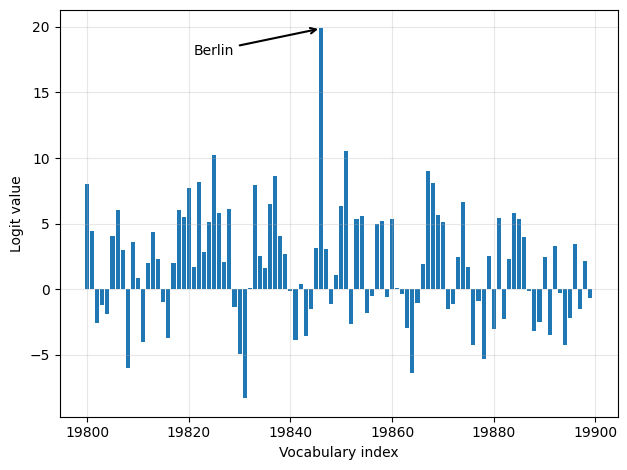

In [11]:
import matplotlib.pyplot as plt

def plot_scores_bar(
    next_token_logits, start=19_800, end=19_900,
    arrow=True, ylabel="Logit value"
):
    # Select vocabulary subsection
    x = torch.arange(start, end)

    # .cpu() is a shortcut for to(torch.device("cpu"))
    logits_section = next_token_logits[0, start:end].float().cpu()

    # Plot logits
    plt.bar(x, logits_section)
    plt.xlabel("Vocabulary index")
    plt.ylabel(ylabel)

    # Highlight max logit
    if arrow:
        max_idx = torch.argmax(logits_section)
        plt.annotate(
            "Berlin",
            xy=(x[max_idx], logits_section[max_idx]),
            xytext=(x[max_idx] - 25, logits_section[max_idx] - 2),
            arrowprops={
                "facecolor": "black", "arrowstyle": "->", "lw": 1.5
            },
            fontsize=10,
        )

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_scores_bar(next_token_logits)

&nbsp;
### 4.4.2 Rescaling token scores (logits) via a temperature parameter

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F08_raschka.webp" width=600>

In [12]:
def scale_logits_by_temperature(logits, temperature):
    if temperature <= 0:
        raise ValueError("Temperature must be positive")
    return logits / temperature

- Technically, it's better to use a bar plot, but lines make it easier to see the difference:

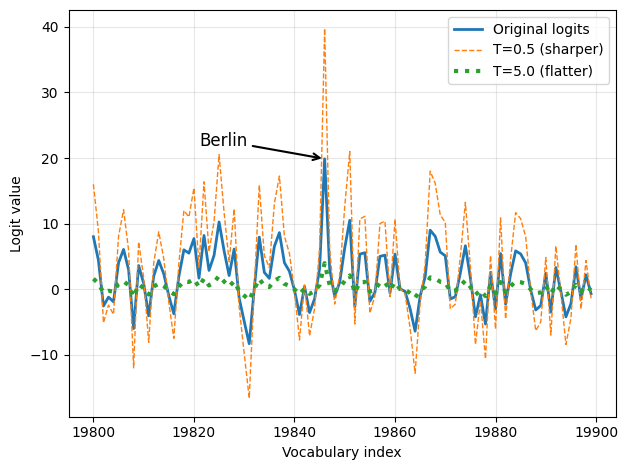

In [13]:
def plot_logits_with_temperature(
    next_token_logits, start=19_800, end=19_900,
    temps=(0.5, 5.0),
):
    x = torch.arange(start, end)
    logits_orig = next_token_logits[0, start:end].float().cpu()

    # Apply temperature scaling
    logits_scaled = [
        scale_logits_by_temperature(logits_orig, T) for T in temps
    ]
    # Plot logits
    plt.plot(x, logits_orig, label="Original logits", lw=2)
    plt.plot(
        x, logits_scaled[0],
        label=f"T={temps[0]} (sharper)", ls="--", lw=1
    )
    plt.plot(
        x, logits_scaled[1],
        label=f"T={temps[1]} (flatter)", ls=":", lw=3
    )

    # Highlight max logit
    max_idx = torch.argmax(logits_orig)
    plt.annotate(
        "Berlin",
        xy=(x[max_idx], logits_orig[max_idx]),
        xytext=(x[max_idx] - 25, logits_orig[max_idx] + 2),
        arrowprops={"facecolor": "black", "arrowstyle": "->", "lw": 1.5},
        fontsize=12,
    )

    plt.xlabel("Vocabulary index")
    plt.ylabel("Logit value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_logits_with_temperature(
    next_token_logits,
    temps=(0.5, 5.0)
)

&nbsp;
### 4.4.3 Sampling the next token from a probability distribution

- Convert logits scores to probability scores, which sum up to 1

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F10_raschka.webp" width=600>

In [14]:
# Step 3.2: Rescale next-token scores
rescaled_logits = scale_logits_by_temperature(next_token_logits, 5.0)

# Step 3.3 Convert rescaled logits into probability scores
next_token_probas = torch.softmax(
    rescaled_logits, dim=-1
)

print("Probability sum:", torch.sum(next_token_probas))

Probability sum: tensor(1., dtype=torch.bfloat16)


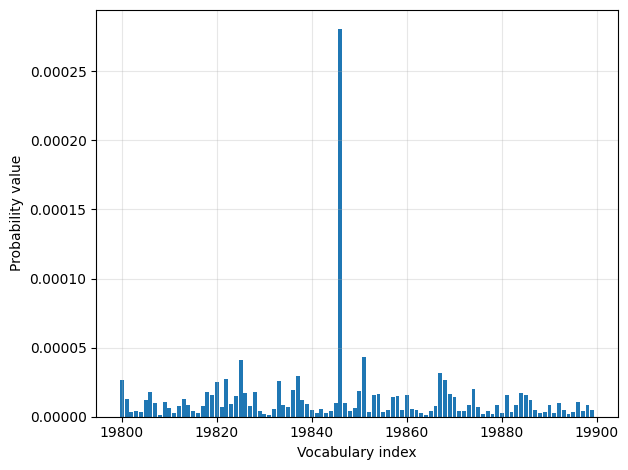

In [15]:
plot_scores_bar(
    next_token_probas, arrow=False, ylabel="Probability value"
)

In [16]:
print("Token ID 19,846 probability:", next_token_probas[:, 19846])

Token ID 19,846 probability: tensor([0.0003], dtype=torch.bfloat16)


In [17]:
print("Highest probability:", max(next_token_probas.squeeze(0)))

Highest probability: tensor(0.0003, dtype=torch.bfloat16)


In [18]:
# Step 3.4: Sample token according to probabilities
torch.manual_seed(123)
print(
    "Sampled token:",
    torch.multinomial(next_token_probas.cpu(), num_samples=1)
)

Sampled token: tensor([[65094]])


In [19]:
print(tokenizer.decode([65094]))

 mistress


In [20]:
def count_samples(probas, num_samples=1000, threshold=1, tokenizer=None):
    # Draw samples according to probabilities
    samples = torch.multinomial(
        probas.cpu(), num_samples=num_samples, replacement=True
    )
    
    # Count how often each index was selected
    counts = torch.bincount(samples.squeeze(0), minlength=1)
    
    # Print results
    for i, c in enumerate(counts):
        if c > threshold:
            if tokenizer is None:
                print(f"Vocab index {i}: {c.item()}x")
            else:
                print(f"'{tokenizer.decode([i])}': {c.item()}x")

In [21]:
torch.manual_seed(123)
count_samples(next_token_probas, tokenizer=tokenizer)

'}': 2x
' </': 2x
' represent': 2x
' Inf': 2x
'()*': 2x
' beside': 2x
' Kob': 2x
'�': 2x


In [22]:
torch.manual_seed(123)
probas_lowT = torch.softmax(
    scale_logits_by_temperature(next_token_logits, 0.35), dim=-1
)
count_samples(probas_lowT, threshold=1, tokenizer=tokenizer)

' __': 158x
' Berlin': 435x
' ____': 169x
' ______': 209x
' Munich': 3x
' Hamburg': 3x
' _____': 18x


In [23]:
print(probas_lowT[0, 19_846])

tensor(0.4199, dtype=torch.bfloat16)


- The `"______"` is likely because the model likely has seen formatting like this in the training set and tries to generate a quiz for the user

&nbsp;
### 4.4.4 Adding temperature scaling to the text generation function

In [24]:
# Exercise 2.2 Appendix B
from reasoning_from_scratch.qwen3 import KVCache

@torch.inference_mode()
def generate_text_temp_stream_cache(
    model,
    token_ids,
    max_new_tokens,
    eos_token_id=None,
    temperature=0.
):
    model.eval()
    cache = KVCache(n_layers=model.cfg["n_layers"])
    model.reset_kv_cache()

    # Step 3.1: Get logits
    out = model(token_ids, cache=cache)[:, -1]
    for _ in range(max_new_tokens):

        ########################################
        # NEW:
        orig_device = token_ids.device

        if temperature is None or temperature == 0.0:
            next_token = torch.argmax(out, dim=-1, keepdim=True)

        else:
            # Step 3.2: Apply temperature scaling on logits
            logits = scale_logits_by_temperature(out, temperature)

            # Step 3.3: Convert to probabilities
            probas = torch.softmax(logits, dim=-1)

            # Step 3.4: Sample token according to probabilities
            next_token = torch.multinomial(probas.cpu(), num_samples=1)
            next_token = next_token.to(orig_device)
            
        #########################################
        if (eos_token_id is not None
                and next_token.item() == eos_token_id):
            break

        yield next_token
        out = model(next_token, cache=cache)[:, -1]

In [25]:
torch.manual_seed(123)
response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_temp_stream_cache,
    temperature=1.1
)

 \boxed{$x = \frac{90}{7}$}

&nbsp;
## 4.5 Balancing diversity and coherence with top-p sampling

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F12_raschka.webp" width=600>

&nbsp;
### 4.5.1 Selecting a subset of top-p tokens

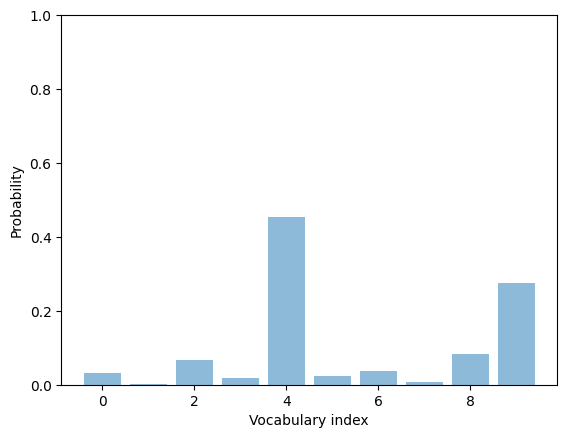

In [26]:
# Step 3.1: Get logits (here: use toy logits for 10 tokens)
toy_logits = torch.tensor(
    [-0.7, -3.0, 0.1, -1.2, 2.0, -1.0, -0.5, -2.0, 0.3, 1.5]
)

# Step 3.2: Apply temperature scaling
toy_logits_scaled = scale_logits_by_temperature(toy_logits, 1.0)

# Step 3.3: Convert to probabilities
toy_probas = torch.softmax(toy_logits_scaled, dim=-1)

plt.bar(
    torch.arange(len(toy_logits_scaled)), toy_probas,
    alpha=0.5
)

plt.ylim([0, 1])
plt.xlabel("Vocabulary index")
plt.ylabel("Probability")
# plt.savefig("12.pdf")
plt.show()

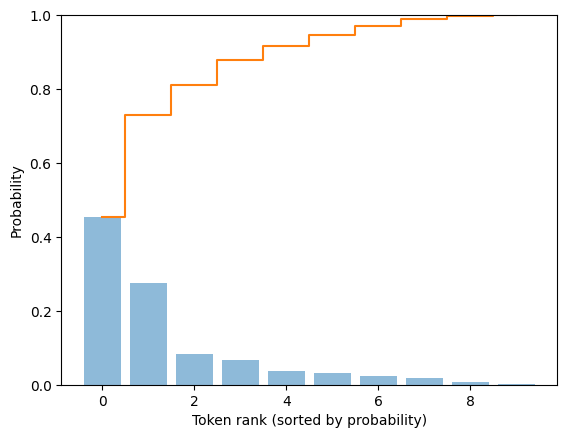

In [27]:
# Step 4.1: Sort by descending probability
sorted_probas, sorted_idx = torch.sort(toy_probas, descending=True)

# Step 4.2: Compute cumulative sum
cumsum = torch.cumsum(sorted_probas, dim=-1)

plt.bar(
    torch.arange(len(sorted_probas)), sorted_probas, 
        alpha=0.5
)
plt.step(
    torch.arange(len(cumsum)), cumsum, 
    where="mid", color="C1", label="Cumulative sum"
)

plt.ylim([0, 1])
plt.xlabel("Token rank (sorted by probability)")
plt.ylabel("Probability")
plt.show()

In [28]:
# Step 4.3.1: Apply top-p threshold (e.g., keep tokens until cumulative mass > 0.8)
top_p = 0.8
keep_mask = cumsum <= top_p
n_kept = torch.sum(keep_mask).item()

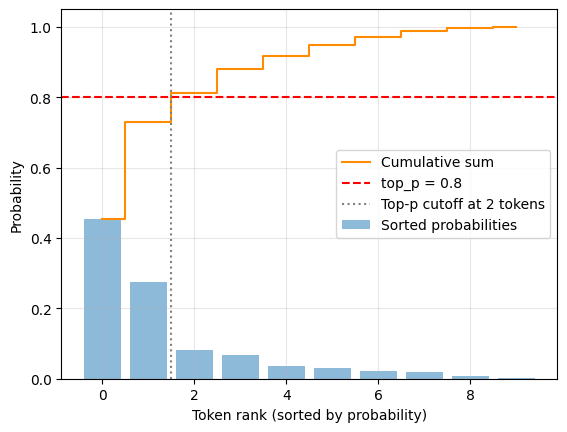

In [29]:
plt.bar(
    torch.arange(len(sorted_probas)), sorted_probas, 
    alpha=0.5, label="Sorted probabilities"
)
plt.step(
    torch.arange(len(cumsum)), cumsum, where="mid",
    color="darkorange", label="Cumulative sum"
)

# Highlight cutoff
plt.axhline(
    top_p, color="red", linestyle="--",
    label=f"top_p = {top_p}"
)
plt.axvline(
    n_kept - 0.5, color="gray", linestyle=":",
    label=f"Top-p cutoff at {n_kept} tokens"
)

plt.xlabel("Token rank (sorted by probability)")
plt.ylabel("Probability")
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1.05)
# plt.savefig("14.pdf")
plt.show()

In [30]:
# Step 4.3.2: Zero out beyond cutoff
kept_sorted = torch.where(
    keep_mask, sorted_probas,
    torch.zeros_like(sorted_probas)
)

# Step 4.3.3: Map back to original order
filtered = torch.zeros_like(toy_probas).scatter(0, sorted_idx, kept_sorted)

print(filtered)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4538, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2752])


In [31]:
# Step 4.4: Renormalize to sum to 1
denom = torch.sum(filtered).clamp_min(1e-12)
renormalized = filtered / denom
print(renormalized)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.6225, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3775])


&nbsp;
### 4.5.2 Adding a top-p filter to the text generation function

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F16_raschka.webp" width=600>

In [32]:
def top_p_filter(probas, top_p):
    if top_p is None or top_p >= 1.0:
        return probas

    # Step 4.1: Sort by descending probability
    sorted_probas, sorted_idx = torch.sort(probas, dim=1, descending=True)

    # Step 4.2: Cumulative sum
    cumprobas = torch.cumsum(sorted_probas, dim=1)

    # Step 4.3.1: Keep tokens where cumprob <= top_p
    keep = cumprobas <= top_p
    # For top_p <= 0, only the highest‑probability token is guaranteed to be kept as a fallback
    keep[:, 0] = True

    # Step 4.3.2: Zero out beyond cutoff
    kept_sorted = torch.where(
        keep, sorted_probas,
        torch.zeros_like(sorted_probas)
    )
    # Step 4.3.3: Map back to original order
    filtered = torch.zeros_like(probas).scatter(1, sorted_idx, kept_sorted)

    # Step 4.4: Renormalize to sum to 1
    denom = torch.sum(filtered, dim=1).clamp_min(1e-12)
    return filtered / denom

In [33]:
with torch.inference_mode():
    next_token_logits = model(input_token_ids)[:, -1]
print(next_token_logits.shape)

torch.Size([1, 151936])


In [34]:
torch.manual_seed(123)
probas_lowT = torch.softmax(
    scale_logits_by_temperature(next_token_logits, 0.35), dim=-1
)
count_samples(probas_lowT, threshold=1, tokenizer=tokenizer)

' __': 158x
' Berlin': 435x
' ____': 169x
' ______': 209x
' Munich': 3x
' Hamburg': 3x
' _____': 18x


In [35]:
torch.manual_seed(123)
probas_lowT = torch.softmax(
    scale_logits_by_temperature(next_token_logits, 0.35), dim=-1
)
probas_lowT_filtered = top_p_filter(probas_lowT, top_p=0.8)

count_samples(probas_lowT_filtered, threshold=1, tokenizer=tokenizer)

' Berlin': 683x
' ______': 317x


In [36]:
@torch.inference_mode()
def generate_text_top_p_stream_cache(
    model,
    token_ids,
    max_new_tokens,
    eos_token_id=None,
    temperature=0.,
    top_p=None
):
    model.eval()
    cache = KVCache(n_layers=model.cfg["n_layers"])
    model.reset_kv_cache()

    # Step 3.1: Get logits
    out = model(token_ids, cache=cache)[:, -1]
    for _ in range(max_new_tokens):

        orig_device = token_ids.device

        if temperature is None or temperature == 1.0:
            next_token = torch.argmax(out, dim=-1, keepdim=True)

        else:
            # Step 3.2: Apply temperature scaling on logits
            logits = scale_logits_by_temperature(out, temperature)

            # Step 3.3: Convert to probabilities
            probas = torch.softmax(logits, dim=-1)

            # (New) Step 4: Apply top-p filter to probabilities
            probas = top_p_filter(probas, top_p)            

            # Step 3.4: Sample token according to probabilities
            next_token = torch.multinomial(probas.cpu(), num_samples=1)
            next_token = next_token.to(orig_device)

        if (eos_token_id is not None
                and next_token.item() == eos_token_id):
            break

        yield next_token
        out = model(next_token, cache=cache)[:, -1]

In [37]:
torch.manual_seed(123)
response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.5,
    top_p=0.8, 
)

 \boxed{18}

&nbsp;
## 4.6 Improving response accuracy with self-consistency

- Generate multiple answers (/reasoning chains) via sampling and vote

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F17_raschka.webp" width=600>

- Similar to classic majority voting, but instead of different models, use different temperature settings
- This method is also described in the [Self-Consistency Improves Chain-of-Thought Reasoning in Language Models](https://arxiv.org/abs/2203.11171) paper
- In short, this method
  - Samples multiple reasoning chains with high temperature and top-p
  - Extracts the final answer from each chain
  - Chooses the most frequent final answer
- Nit: this is called [plurality vote](https://en.wikipedia.org/wiki/Plurality_(voting)) (in American English), not majority vote

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F18_raschka.webp?1" width=600>

In [38]:
from reasoning_from_scratch.ch03 import extract_final_candidate
from collections import Counter

def self_consistency_vote(
    model, tokenizer, prompt, device,
    num_samples=10, temperature=0.8, top_p=0.9, max_new_tokens=2048,
    show_progress=True, show_long_answer=False, seed=None,
):
    full_answers, short_answers = [], []

    # 1) Sample multiple answers
    for i in range(num_samples):
        if seed is not None:
            torch.manual_seed(seed + i + 1)

        answer = generate_text_stream_concat_flex(
            model=model, tokenizer=tokenizer, prompt=prompt, device=device,
            max_new_tokens=max_new_tokens, verbose=show_long_answer,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature, top_p=top_p,
        )

        # 2) Extract the final (short) answer from each answer
        short = extract_final_candidate(
            answer, fallback="number_then_full"
        )
        full_answers.append(answer)
        short_answers.append(short)
        if show_progress:
            print(f"[Sample {i+1}/{num_samples}] → {short!r}")

    # 3) Choose the most frequent final answer (self-consistency vote)
    counts = Counter(short_answers)
    groups = {s: [] for s in counts}
    for idx, s in enumerate(short_answers):
        groups[s].append(idx)

    mc = counts.most_common()
    if not mc:
        majority_winners, final_answer = [], None
    else:
        top_freq = mc[0][1]
        majority_winners = [s for s, f in mc if f == top_freq]
        final_answer = mc[0][0] if len(majority_winners) == 1 else None

    return {
        "full_answers": full_answers,
        "short_answers": short_answers,
        "counts": dict(counts),
        "groups": groups,
        "majority_winners": majority_winners,
        "final_answer": final_answer,
    }

- Additional tips
  - If all (long) answers look nearly identical, increase temperature gently to increase diversity  
  - If (long) answers look off, decrease temperature

In [39]:
results = self_consistency_vote(
    model,
    tokenizer,
    prompt,
    device=device,
    num_samples=5,
    temperature=0.8,
    top_p=0.9,
    max_new_tokens=2048,
    seed=123,
    show_progress=True,
)

[Sample 1/5] → '83'
[Sample 2/5] → '22'
[Sample 3/5] → '54'
[Sample 4/5] → '83'
[Sample 5/5] → '26'


In [40]:
print(results["final_answer"])

83


In [41]:
print(results["full_answers"][3])

 To solve the equation, we first need to find the value of $3x-9$ by setting it equal to twice the value of $x+37$:

$$3x-9 = 2(x+37)$$

Next, we distribute the 2 on the right side of the equation:

$$3x-9 = 2x+74$$

Now, we can subtract $2x$ from both sides of the equation to isolate the variable:

$$x-9 = 74$$

Finally, we add 9 to both sides of the equation to solve for $x$:

$$x = 83$$

Therefore, the value of $x$ is $\boxed{83}$.


In [42]:
results = self_consistency_vote(
    model,
    tokenizer,
    prompt + "\n\nExplain step by step.",
    device=device,
    num_samples=5,
    temperature=0.8,
    top_p=0.9,
    max_new_tokens=2048,
    seed=123,
    show_progress=True,
)

[Sample 1/5] → '83'
[Sample 2/5] → '83'
[Sample 3/5] → '83'
[Sample 4/5] → '83'
[Sample 5/5] → '83'


- Parallel sampling like this is also done by Claude 4 (https://www.anthropic.com/news/claude-4); in addition, Claude 4 uses an internal model for scoring responses
- A scorer can be similar to the LLM judge in Appendix F (F.5 Judging responses with other LLMs)
- In the next chapter, we will also introduce a scoring method based on confidence scores (we can also use it as a tie-breaker)

Below are the results of the different methods on a cuda device (DGX Spark) evaluated on the full MATH-500 test set with all 500 problems

|    | Method                                       | Model     | Accuracy | Time       |
|----|----------------------------------------------|-----------|----------|------------|
| 1  | Baseline (chapter 3), greedy decoding        | Base      | 15.2%    | 10.1 min   |
| 2  | Baseline (chapter 3), greedy decoding        | Reasoning | 48.2%    | 182.1 min  |
| 3  | Chain-of-thought prompting ("CoT")           | Base      | 40.6%    | 84.5 min   |
| 4  | Temperature and top-p ("Top-p")              | Base      | 17.8%    | 30.7 min   |
| 5  | "Top-p" + Self-consistency (n=3)             | Base      | 29.6%    | 97.6 min   |
| 6  | "Top-p" + Self-consistency (n=5)             | Base      | 27.8%    | 116.8 min  |
| 7  | "Top-p" + Self-consistency (n=10)            | Base      | 31.6%    | 300.4 min  |
| 8  | "Top-p" + "CoT"                              | Base      | 33.4%    | 129.2 min  |
| 9  | Self-consistency (n=3) + "Top-p" + "CoT"     | Base      | 42.2%    | 211.6 min  |
| 10 | Self-consistency (n=5) + "Top-p" + "CoT"     | Base      | 48.0%    | 452.9 min  |
| 11 | Self-consistency (n=10) + "Top-p" + "CoT"    | Base      | 52.0%    | 862.6 min  |
| 12 | Self-consistency (n=3) + "Top-p" + "CoT"     | Reasoning | 55.2%    | 544.4 min  |

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch04/CH04_F19_raschka.webp" width=600>

&nbsp;
## 4.7 Summary

- No code in this section